In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import pickle as pkl
import cv2
import imutils
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications import ResNet50V2, DenseNet121, VGG19, EfficientNetB7, InceptionV3, MobileNetV3Large
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet_v2_preprocess_input
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess_input
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg19_preprocess_input
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_v3_preprocess_input
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as mobilenet_v3_preprocess_input
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, Conv2DTranspose, Reshape, Input, ReLU, LeakyReLU
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [16]:
""" Dataset directories """

dataset_dir = "filtered_dataset"
# dataset_dir = "archive/Data"

In [17]:
""" Get the first image from the healthy directory """

first_image_file = os.listdir(f"{dataset_dir}/Not Dementia")[0]
img = plt.imread(f"{dataset_dir}/Not Dementia/{first_image_file}")

img_height, img_width, _ = img.shape

# img_size = 224
img_size = min(img_height, img_width)

print(f"Image size: {img_height}x{img_width} -> {img_size}")

Image size: 248x496 -> 248


In [18]:
""" Set batch size """

batch_size = 32

#### General preprocessing and augmentation


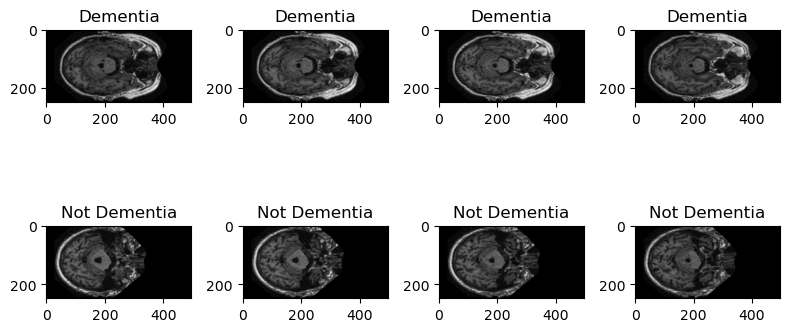

In [19]:
""" Display raw images from different classes """

plt.figure(figsize=(8, 8))

for i, subdir in enumerate(os.listdir(dataset_dir)):
    subdir_path = os.path.join(dataset_dir, subdir)
    img_files = os.listdir(subdir_path)[:4]

    for j, img_file in enumerate(img_files):
        img_path = os.path.join(subdir_path, img_file)
        img = plt.imread(img_path)

        plt.subplot(4, 4, i * 4 + j + 1)
        plt.imshow(img)
        plt.title(subdir)

plt.tight_layout()
plt.show()

In [20]:
# plt.figure(figsize=(16, 8))

# # Display sample training images
# for i in range(9):
#     plt.subplot(3, 6, i + 1)
#     for X_batch, Y_batch in train_generator:
#         image = X_batch[0]
#         label = Y_batch[0]
#         plt.imshow(image)
#         plt.title("Train: " + class_labels[np.argmax(label)])
#         break

# # Display sample test images
# for i in range(9):
#     plt.subplot(3, 6, i + 10)
#     for X_batch, Y_batch in test_generator:
#         image = X_batch[0]
#         label = Y_batch[0]
#         plt.imshow(image)
#         plt.title("Test: " + class_labels[np.argmax(label)])
#         break

# plt.tight_layout()
# plt.show()

#### Custom preprocessing on Images


In [21]:
def apply_clahe(img):
    # Convert image to grayscale
    grayscale_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) for contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized_img = clahe.apply(grayscale_img)

    return equalized_img


def enhance_sharpness(img):
    # Apply Laplacian sharpening to enhance details
    laplacian = cv2.Laplacian(img, cv2.CV_8U, ksize=3)

    # Add the original image with the sharpened details
    sharpened_img = cv2.addWeighted(img, 1.5, laplacian, -0.5, 0)

    return sharpened_img


def crop_image(img, add_pixels_value=1):
    # Apply Gaussian blur to reduce noise
    gray_blur = cv2.GaussianBlur(img, (5, 5), 0)

    # Thresholding to create a binary image
    _, thresh = cv2.threshold(gray_blur, 45, 255, cv2.THRESH_BINARY)

    # Morphological operations (erosion and dilation) to remove noise
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours
    contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)

    # If no contours found, return original image
    if len(contours) == 0:
        return img

    # Get the largest contour
    largest_contour = max(contours, key=cv2.contourArea)

    # Get the bounding box of the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Add extra pixels to the bounding box if specified
    x -= add_pixels_value
    y -= add_pixels_value
    w += add_pixels_value * 2
    h += add_pixels_value * 2

    # Ensure the bounding box coordinates are within image bounds
    x = max(x, 0)
    y = max(y, 0)
    w = min(w, img.shape[1])
    h = min(h, img.shape[0])

    # Crop the image using the bounding box
    cropped_img = img[y : y + h, x : x + w].copy()

    return cropped_img


def resize_image(img, size):
    # Resize the image to the specified size
    resized_img = cv2.resize(img, (size, size), interpolation=cv2.INTER_AREA)

    return resized_img

In [22]:
prep_dir_1 = "dataset_preprocessed_1_clahe"
prep_dir_2 = "dataset_preprocessed_2_sharp"
prep_dir_3 = "dataset_preprocessed_3_crop"
prep_dir_4 = "dataset_preprocessed_4_final"

In [9]:
"""
    Keep toggle as False to only get the final preprocessed images.
"""

# Local save intermediate outputs toggle
toggle = False

# Create directories if they don't exist
for prep_dir in [prep_dir_1, prep_dir_2, prep_dir_3, prep_dir_4]:
    if not os.path.exists(prep_dir):
        os.makedirs(prep_dir)

for subdir in os.listdir(dataset_dir):
    subdir_path = os.path.join(dataset_dir, subdir)

    # Create subdirectories in each preprocessing directory
    for prep_dir in [prep_dir_1, prep_dir_2, prep_dir_3, prep_dir_4]:
        new_subdir_path = os.path.join(prep_dir, subdir)
        if not os.path.exists(new_subdir_path):
            os.makedirs(new_subdir_path)

    for filename in os.listdir(subdir_path):
        img_path = os.path.join(subdir_path, filename)
        img = plt.imread(img_path)

        # Apply CLAHE and save the result in prep_dir_1
        clahe_img = apply_clahe(img)
        new_filename = os.path.join(prep_dir_1, subdir, filename)
        if toggle:
            plt.imsave(new_filename, clahe_img, cmap="gray")

        # Enhance sharpness and save the result in prep_dir_2
        sharp_img = enhance_sharpness(clahe_img)
        new_filename = os.path.join(prep_dir_2, subdir, filename)
        if toggle:
            plt.imsave(new_filename, sharp_img, cmap="gray")

        # Crop image and save the result in prep_dir_3
        cropp_image = crop_image(sharp_img)
        new_filename = os.path.join(prep_dir_3, subdir, filename)
        if toggle:
            plt.imsave(new_filename, cropp_image, cmap="gray")

        # Resize image to 224x224 and save the result in prep_dir_4
        preprocessed_img = resize_image(cropp_image, img_size)
        new_filename = os.path.join(prep_dir_4, subdir, filename)
        plt.imsave(new_filename, preprocessed_img, cmap="gray")

In [50]:
prep_dir = prep_dir_4

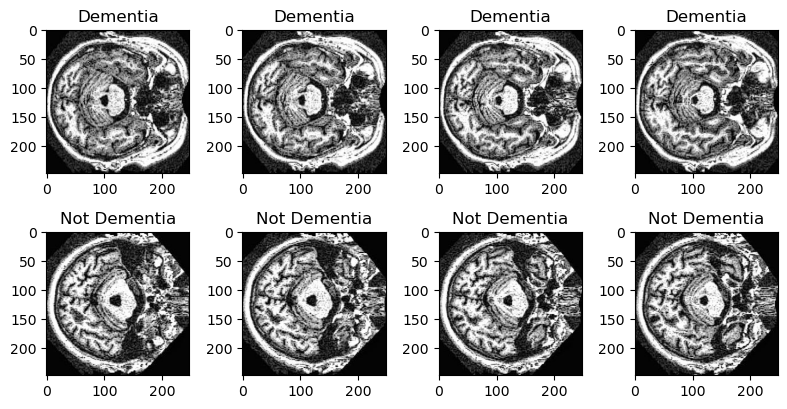

In [51]:
""" Display raw images from different classes """

plt.figure(figsize=(8, 8))

for i, subdir in enumerate(os.listdir(prep_dir)):
    subdir_path = os.path.join(prep_dir, subdir)
    img_files = os.listdir(subdir_path)[:4]

    for j, img_file in enumerate(img_files):
        img_path = os.path.join(subdir_path, img_file)
        img = plt.imread(img_path)

        plt.subplot(4, 4, i * 4 + j + 1)
        plt.imshow(img)
        plt.title(subdir)

plt.tight_layout()
plt.show()

In [52]:
""" Model configuration """
epochs_number = 200

""" Set optimizer """
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
# optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# optimizer = SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

""" Set early stopping """
early_stopping = EarlyStopping(monitor="val_accuracy", patience=10, min_delta=0.001, restore_best_weights=True)

""" Set learning rate annealer """
learning_rate_reduction = ReduceLROnPlateau(monitor="val_accuracy", patience=3, verbose=1, factor=0.75, min_lr=0.00001)

In [53]:
datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    height_shift_range=0.2,
    width_shift_range=0.2,
    rotation_range=45,
    validation_split=0.1,
)

train_generator = datagen.flow_from_directory(prep_dir, target_size=(img_size, img_size), batch_size=batch_size, class_mode="categorical", subset="training", shuffle=True, seed=42)
test_generator = datagen.flow_from_directory(prep_dir, target_size=(img_size, img_size), batch_size=batch_size, class_mode="categorical", subset="validation", shuffle=True, seed=42)

Found 34588 images belonging to 2 classes.
Found 3842 images belonging to 2 classes.


In [54]:
""" Get class labels """
class_labels = list(train_generator.class_indices.keys())

## 1. ResNet-50 V2


In [55]:
""" Number of classes"""
num_classes = len(class_labels)

In [56]:
""" Load ResNet50V2 model """
base_resNet_model = ResNet50V2(weights="imagenet", include_top=False, input_shape=(img_size, img_size, 3))

""" Freeze the base model """
for layer in base_resNet_model.layers:
    layer.trainable = False

""" Add custom layers """
x = base_resNet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.3)(x)
x = Dense(256)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.3)(x)
x = Dense(128)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation="softmax")(x)

""" Create model """
resnet_model = Model(inputs=base_resNet_model.input, outputs=predictions)

""" Compile model """
resnet_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [57]:
""" Train model """
resNet_history = resnet_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs_number,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[learning_rate_reduction, early_stopping],
)

Epoch 1/200
1080/1080 [==============================] - 337s 302ms/step - loss: 0.7482 - accuracy: 0.5422 - val_loss: 0.6917 - val_accuracy: 0.5589
Epoch 2/200
 291/1080 [=======>......................] - ETA: 3:35 - loss: 0.7011 - accuracy: 0.5550

KeyboardInterrupt: 

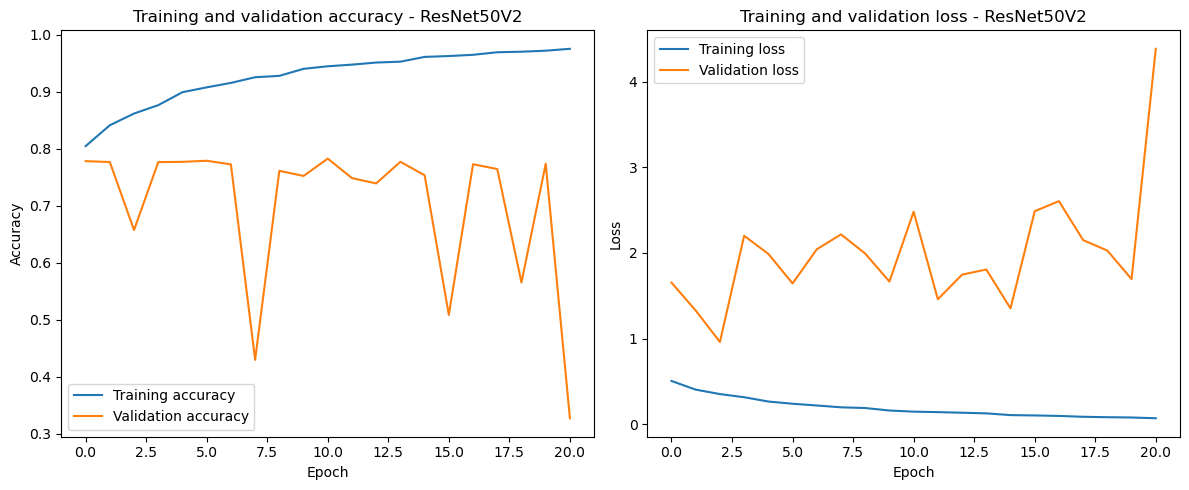

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

""" Plot training and validation accuracy """
axs[0].plot(resNet_history.history["accuracy"], label="Training accuracy")
axs[0].plot(resNet_history.history["val_accuracy"], label="Validation accuracy")
axs[0].set_title("Training and validation accuracy - ResNet50V2")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")
axs[0].legend()

""" Plot training and validation loss """
axs[1].plot(resNet_history.history["loss"], label="Training loss")
axs[1].plot(resNet_history.history["val_loss"], label="Validation loss")
axs[1].set_title("Training and validation loss - ResNet50V2")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
""" Save model """
resnet_model.save("models/resNet_model.h5")

""" Save history """
with open("models/resNet_history.pkl", "wb") as f:
    pkl.dump(resNet_history.history, f)

c:\ProgramData\anaconda3\envs\tf_env\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


## 2. DenseNet-121 model


In [ ]:
""" Model configuration """
epochs_number = 200

""" Set optimizer """
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
# optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# optimizer = SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

""" Set early stopping """
early_stopping = EarlyStopping(monitor="val_accuracy", patience=10, min_delta=0.001, restore_best_weights=True)

""" Set learning rate annealer """
learning_rate_reduction = ReduceLROnPlateau(monitor="val_accuracy", patience=3, verbose=1, factor=0.75, min_lr=0.00001)

In [ ]:
# Load pre-trained DenseNet121 model
base_denseNet_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(img_size, img_size, 3))

# Freeze convolutional layers
for layer in base_denseNet_model.layers:
    layer.trainable = False

# Add custom classification head
x = base_denseNet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.3)(x)
x = Dense(256)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.3)(x)
x = Dense(128)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation="softmax")(x)

# Create model
denseNet_model = Model(inputs=base_denseNet_model.input, outputs=predictions)

# Compile model
denseNet_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
""" Train model """
denseNet_history = denseNet_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs_number,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[learning_rate_reduction, early_stopping],
)

Epoch 1/200
2160/2160 [==============================] - 149s 66ms/step - loss: 0.4274 - accuracy: 0.8309 - val_loss: 0.8149 - val_accuracy: 0.7695
Epoch 2/200
2160/2160 [==============================] - 140s 65ms/step - loss: 0.3221 - accuracy: 0.8723 - val_loss: 0.7164 - val_accuracy: 0.7544
Epoch 3/200
2160/2160 [==============================] - 140s 65ms/step - loss: 0.2728 - accuracy: 0.8923 - val_loss: 0.8908 - val_accuracy: 0.7659
Epoch 4/200
2160/2160 [==============================] - 140s 65ms/step - loss: 0.2467 - accuracy: 0.9038 - val_loss: 0.8744 - val_accuracy: 0.7068

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00017797851614886895.
Epoch 5/200
2160/2160 [==============================] - 140s 65ms/step - loss: 0.2116 - accuracy: 0.9180 - val_loss: 0.8878 - val_accuracy: 0.7799
Epoch 6/200
2160/2160 [==============================] - 140s 65ms/step - loss: 0.1981 - accuracy: 0.9240 - val_loss: 0.9345 - val_accuracy: 0.7582
Epoch 7/200
2160/2160 [=======

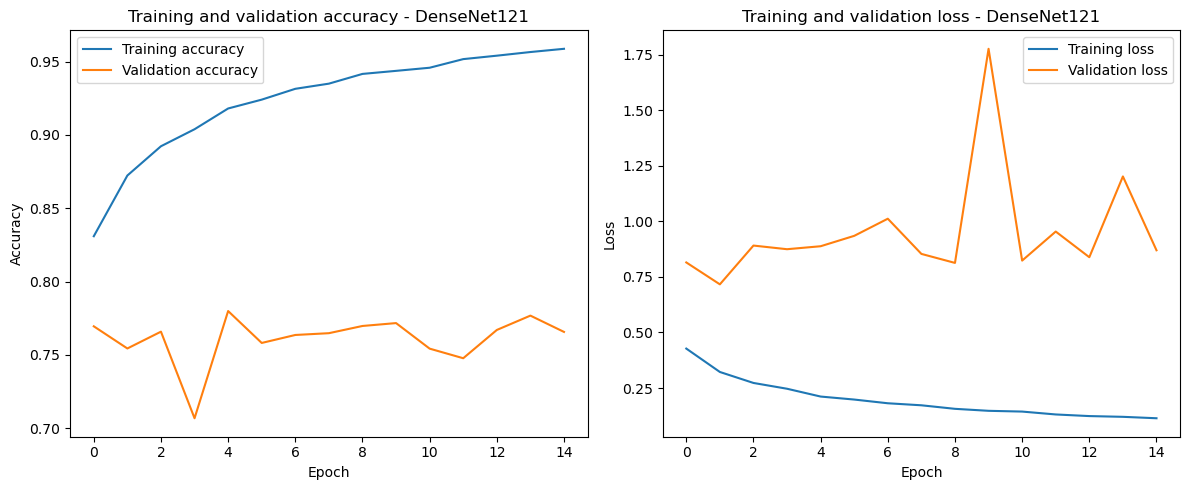

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation accuracy
axs[0].plot(denseNet_history.history["accuracy"], label="Training accuracy")
axs[0].plot(denseNet_history.history["val_accuracy"], label="Validation accuracy")
axs[0].set_title("Training and validation accuracy - DenseNet121")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")
axs[0].legend()

# Plot training and validation loss
axs[1].plot(denseNet_history.history["loss"], label="Training loss")
axs[1].plot(denseNet_history.history["val_loss"], label="Validation loss")
axs[1].set_title("Training and validation loss - DenseNet121")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Save trained model
denseNet_model.save("models/denseNet_model.h5")

# Save history
with open("models/denseNet_history.pkl", "wb") as f:
    pkl.dump(denseNet_history.history, f)

## 3. VGG19 model


In [ ]:
""" Model configuration """
epochs_number = 200

""" Set optimizer """
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
# optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# optimizer = SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

""" Set early stopping """
early_stopping = EarlyStopping(monitor="val_accuracy", patience=10, min_delta=0.001, restore_best_weights=True)

""" Set learning rate annealer """
learning_rate_reduction = ReduceLROnPlateau(monitor="val_accuracy", patience=3, verbose=1, factor=0.75, min_lr=0.00001)

In [ ]:
""" Load the VGG19 model """
base_vgg_model = VGG19(weights="imagenet", include_top=False, input_shape=(img_size, img_size, 3))

# Freeze convolutional layers
for layer in base_vgg_model.layers:
    layer.trainable = False

# Add custom classification head
x = base_vgg_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.3)(x)
x = Dense(256)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.3)(x)
x = Dense(128)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation="softmax")(x)

# Create model
vgg_model = Model(inputs=base_vgg_model.input, outputs=predictions)
# Compile model
vgg_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
# Train the model
vgg_history = vgg_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs_number,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[learning_rate_reduction, early_stopping],
)

Epoch 1/200
2160/2160 [==============================] - 189s 87ms/step - loss: 0.4791 - accuracy: 0.8107 - val_loss: 0.6334 - val_accuracy: 0.7608
Epoch 2/200
2160/2160 [==============================] - 186s 86ms/step - loss: 0.3833 - accuracy: 0.8447 - val_loss: 0.6126 - val_accuracy: 0.7655
Epoch 3/200
2160/2160 [==============================] - 186s 86ms/step - loss: 0.3415 - accuracy: 0.8629 - val_loss: 0.6235 - val_accuracy: 0.7618
Epoch 4/200
2160/2160 [==============================] - 187s 87ms/step - loss: 0.3078 - accuracy: 0.8763 - val_loss: 0.6588 - val_accuracy: 0.7535
Epoch 5/200
2160/2160 [==============================] - 187s 86ms/step - loss: 0.2783 - accuracy: 0.8910 - val_loss: 0.6689 - val_accuracy: 0.7648

Epoch 00005: ReduceLROnPlateau reducing learning rate to 5.6313510867767036e-05.
Epoch 6/200
2160/2160 [==============================] - 186s 86ms/step - loss: 0.2536 - accuracy: 0.9013 - val_loss: 0.6964 - val_accuracy: 0.7525
Epoch 7/200
2160/2160 [=======

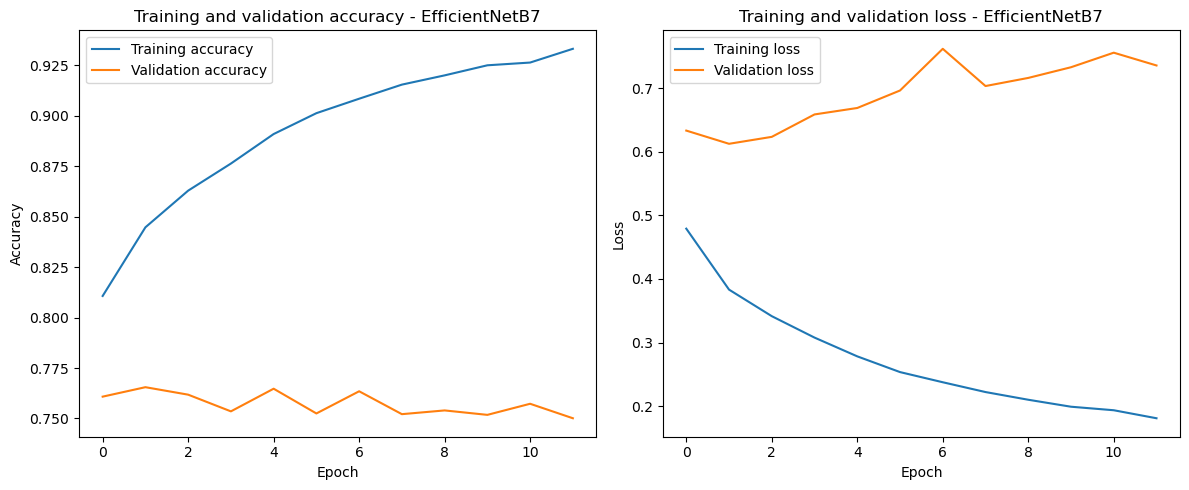

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation accuracy
axs[0].plot(vgg_history.history["accuracy"], label="Training accuracy")
axs[0].plot(vgg_history.history["val_accuracy"], label="Validation accuracy")
axs[0].set_title("Training and validation accuracy - VGG19")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")
axs[0].legend()

# Plot training and validation loss
axs[1].plot(vgg_history.history["loss"], label="Training loss")
axs[1].plot(vgg_history.history["val_loss"], label="Validation loss")
axs[1].set_title("Training and validation loss - VGG19")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Save the trained model
vgg_model.save("models/vgg_model.h5")

# Save the history
with open("models/vgg_history.pkl", "wb") as f:
    pkl.dump(vgg_history.history, f)

## 4. EfficientNet-B7


In [ ]:
""" Model configuration """
epochs_number = 200

""" Set optimizer """
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
# optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# optimizer = SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

""" Set early stopping """
early_stopping = EarlyStopping(monitor="val_accuracy", patience=10, min_delta=0.001, restore_best_weights=True)

""" Set learning rate annealer """
learning_rate_reduction = ReduceLROnPlateau(monitor="val_accuracy", patience=3, verbose=1, factor=0.75, min_lr=0.00001)

In [ ]:
""" Load the EfficientNet model """

base_efficientNet_model = EfficientNetB7(weights="imagenet", include_top=False, input_shape=(img_size, img_size, 3))

# Freeze convolutional layers
for layer in base_efficientNet_model.layers:
    layer.trainable = False

# Add custom classification head
x = base_efficientNet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.3)(x)
x = Dense(256)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.3)(x)
x = Dense(128)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation="softmax")(x)

# Create model
efficientNet_model = Model(inputs=base_efficientNet_model.input, outputs=predictions)

# Compile model
efficientNet_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
# Train the model
efficientNet_history = efficientNet_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs_number,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[learning_rate_reduction, early_stopping],
)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation accuracy
axs[0].plot(efficientNet_history.history["accuracy"], label="Training accuracy")
axs[0].plot(efficientNet_history.history["val_accuracy"], label="Validation accuracy")
axs[0].set_title("Training and validation accuracy - EfficientNetB7")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")
axs[0].legend()

# Plot training and validation loss
axs[1].plot(efficientNet_history.history["loss"], label="Training loss")
axs[1].plot(efficientNet_history.history["val_loss"], label="Validation loss")
axs[1].set_title("Training and validation loss - EfficientNetB7")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Save trained model
efficientNet_model.save("models/efficientNet_model.h5")

# Save history
with open("models/efficientNet_history.pkl", "wb") as f:
    pkl.dump(efficientNet_history.history, f)

## 5. Inception-V3 model


In [ ]:
""" Model configuration """
epochs_number = 200

""" Set optimizer """
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
# optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# optimizer = SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

""" Set early stopping """
early_stopping = EarlyStopping(monitor="val_accuracy", patience=10, min_delta=0.001, restore_best_weights=True)

""" Set learning rate annealer """
learning_rate_reduction = ReduceLROnPlateau(monitor="val_accuracy", patience=3, verbose=1, factor=0.75, min_lr=0.00001)

In [ ]:
""" Load the Inception model """

base_inception_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(img_size, img_size, 3))

# Freeze convolutional layers
for layer in base_inception_model.layers:
    layer.trainable = False

# Add custom classification head
x = base_inception_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.3)(x)
x = Dense(256)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.3)(x)
x = Dense(128)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation="softmax")(x)

# Create model
inception_model = Model(inputs=base_inception_model.input, outputs=predictions)

# Compile model
inception_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
# Train the model
inception_history = inception_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs_number,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[learning_rate_reduction, early_stopping],
)

Epoch 1/200
2160/2160 [==============================] - 126s 57ms/step - loss: 0.6025 - accuracy: 0.7763 - val_loss: 0.6843 - val_accuracy: 0.7635
Epoch 2/200
2160/2160 [==============================] - 126s 59ms/step - loss: 0.5332 - accuracy: 0.7931 - val_loss: 0.6413 - val_accuracy: 0.7503
Epoch 3/200
2160/2160 [==============================] - 124s 58ms/step - loss: 0.5007 - accuracy: 0.8056 - val_loss: 0.8527 - val_accuracy: 0.7745
Epoch 4/200
2160/2160 [==============================] - 126s 58ms/step - loss: 0.4710 - accuracy: 0.8160 - val_loss: 0.7066 - val_accuracy: 0.7650
Epoch 5/200
2160/2160 [==============================] - 131s 61ms/step - loss: 0.4490 - accuracy: 0.8253 - val_loss: 0.7035 - val_accuracy: 0.7408
Epoch 6/200
2160/2160 [==============================] - 135s 63ms/step - loss: 0.4254 - accuracy: 0.8318 - val_loss: 0.7543 - val_accuracy: 0.7633

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0007500000356230885.
Epoch 7/200
2160/2160 [========

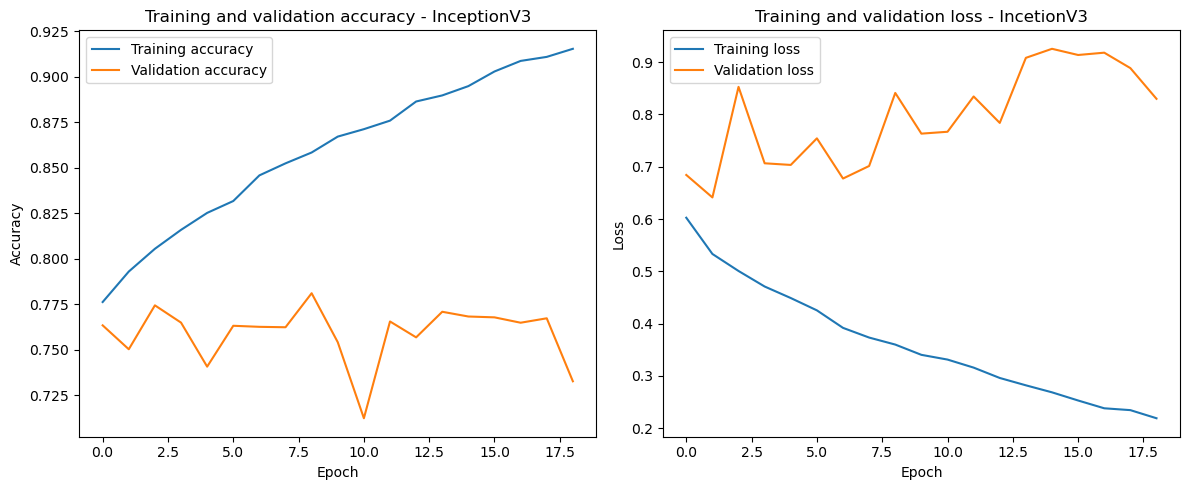

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation accuracy
axs[0].plot(inception_history.history["accuracy"], label="Training accuracy")
axs[0].plot(inception_history.history["val_accuracy"], label="Validation accuracy")
axs[0].set_title("Training and validation accuracy - InceptionV3")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")
axs[0].legend()

# Plot training and validation loss
axs[1].plot(inception_history.history["loss"], label="Training loss")
axs[1].plot(inception_history.history["val_loss"], label="Validation loss")
axs[1].set_title("Training and validation loss - IncetionV3")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Save trained model
inception_model.save("models/inception_model.h5")

# Save history
with open("models/inception_history.pkl", "wb") as f:
    pkl.dump(inception_history.history, f)

## 6. MobileNet model


In [ ]:
""" Model configuration """
epochs_number = 200

""" Set optimizer """
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
# optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# optimizer = SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

""" Set early stopping """
early_stopping = EarlyStopping(monitor="val_accuracy", patience=10, min_delta=0.001, restore_best_weights=True)

""" Set learning rate annealer """
learning_rate_reduction = ReduceLROnPlateau(monitor="val_accuracy", patience=3, verbose=1, factor=0.75, min_lr=0.00001)

In [ ]:
""" Load the MobileNet model """
base_mobileNet_model = MobileNetV3Large(weights="imagenet", include_top=False, input_shape=(img_size, img_size, 3))

# Freeze convolutional layers
for layer in base_mobileNet_model.layers:
    layer.trainable = False

# Add custom classification head
x = base_mobileNet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.3)(x)
x = Dense(256)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.3)(x)
x = Dense(128)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation="softmax")(x)

# Create model
mobileNet_model = Model(inputs=base_mobileNet_model.input, outputs=predictions)

# Compile model
mobileNet_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
# Train the model
mobileNet_history = mobileNet_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs_number,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[learning_rate_reduction, early_stopping],
)

In [ ]:
# Save trained model
mobileNet_model.save("models/mobileNet_model.h5")

# Save history
with open("models/mobileNet_history.pkl", "wb") as f:
    pkl.dump(mobileNet_history.history, f)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation accuracy
axs[0].plot(mobileNet_history.history["accuracy"], label="Training accuracy")
axs[0].plot(mobileNet_history.history["val_accuracy"], label="Validation accuracy")
axs[0].set_title("Training and validation accuracy - MobileNetV3")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")
axs[0].legend()

# Plot training and validation loss
axs[1].plot(mobileNet_history.history["loss"], label="Training loss")
axs[1].plot(mobileNet_history.history["val_loss"], label="Validation loss")
axs[1].set_title("Training and validation loss - MobileNetV3")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend()

plt.tight_layout()
plt.show()

## 7. CNN model


In [ ]:
# # Custom CNN architecture
# custom_model = Sequential(
#     [
#         Conv2D(32, (3, 3), activation="relu", input_shape=(img_size, img_size, 3)),
#         MaxPooling2D((2, 2)),
#         Conv2D(64, (3, 3), activation="relu"),
#         MaxPooling2D((2, 2)),
#         Conv2D(128, (3, 3), activation="relu"),
#         MaxPooling2D((2, 2)),
#         Conv2D(128, (3, 3), activation="relu"),
#         MaxPooling2D((2, 2)),
#         Flatten(),
#         Dense(512, activation="relu"),
#         Dropout(0.5),
#         Dense(num_classes, activation="softmax"),
#     ]
# )

# # Compile the model
# custom_model.compile(optimizer=adam_optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
# # custom_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy", f1_m])

In [ ]:
# # Train the model
# custom_CNN_history = custom_model.fit(
#     train_generator, steps_per_epoch=train_generator.samples // batch_size, epochs=epochs_number, validation_data=test_generator, validation_steps=test_generator.samples // batch_size, callbacks=[learning_rate_reduction, early_stopping]
# )

In [ ]:
# # Save the trained model
# custom_model.save("custom_CNN_model.h5")

In [ ]:
# plt.plot(custom_CNN_history.history["accuracy"], label="Training accuracy")
# plt.plot(custom_CNN_history.history["val_accuracy"], label="Validation accuracy")
# plt.title("Training and validation accuracy - Custom CNN")
# plt.xlabel("Epoch")
# plt.ylabel("Accuracy")
# plt.legend()
# plt.show()

## Evaluate models


In [ ]:
# Table comparing the performance of models
resNet_accuracy = resNet_history.history["accuracy"][-1]
resNet_val_accuracy = resNet_history.history["val_accuracy"][-1]

denseNet_accuracy = denseNet_history.history["accuracy"][-1]
denseNet_val_accuracy = denseNet_history.history["val_accuracy"][-1]

vgg_accuracy = vgg_history.history["accuracy"][-1]
vgg_val_accuracy = vgg_history.history["val_accuracy"][-1]

inception_accuracy = inception_history.history["accuracy"][-1]
inception_val_accuracy = inception_history.history["val_accuracy"][-1]

mobileNet_accuracy = mobileNet_history.history["accuracy"][-1]
mobileNet_val_accuracy = mobileNet_history.history["val_accuracy"][-1]

efficientNet_accuracy = efficientNet_history.history["accuracy"][-1]
efficientNet_val_accuracy = efficientNet_history.history["val_accuracy"][-1]

model_comparison = pd.DataFrame(
    {
        "Model": [
            "ResNet50V2",
            "DenseNet121",
            "VGG19",
            "InceptionV3",
            "MobileNetV3",
            "EfficientNetB7",
        ],
        "Train Accuracy": [
            resNet_accuracy,
            denseNet_accuracy,
            vgg_accuracy,
            inception_accuracy,
            mobileNet_accuracy,
            efficientNet_accuracy,
        ],
        "Validation Accuracy": [
            resNet_val_accuracy,
            denseNet_val_accuracy,
            vgg_val_accuracy,
            inception_val_accuracy,
            mobileNet_val_accuracy,
            efficientNet_val_accuracy,
        ],
    }
)

# Sort the models by validation accuracy
model_comparison = model_comparison.sort_values(by="Validation Accuracy", ascending=False).reset_index(drop=True)

model_comparison

,Model,Train Accuracy,Validation Accuracy
0,DenseNet121,0.958680,0.765683
1,VGG19,0.933217,0.750116
2,InceptionV3,0.915436,0.732755
3,ResNet50V2,0.974942,0.327546


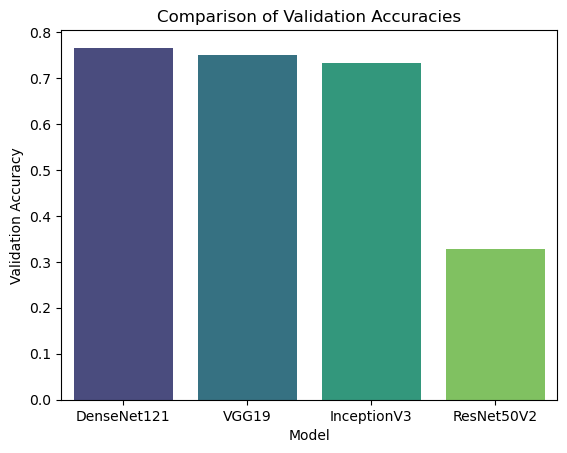

In [ ]:
sns.barplot(x="Model", y="Validation Accuracy", data=model_comparison, palette="viridis")
plt.title("Comparison of Validation Accuracies")
plt.show()

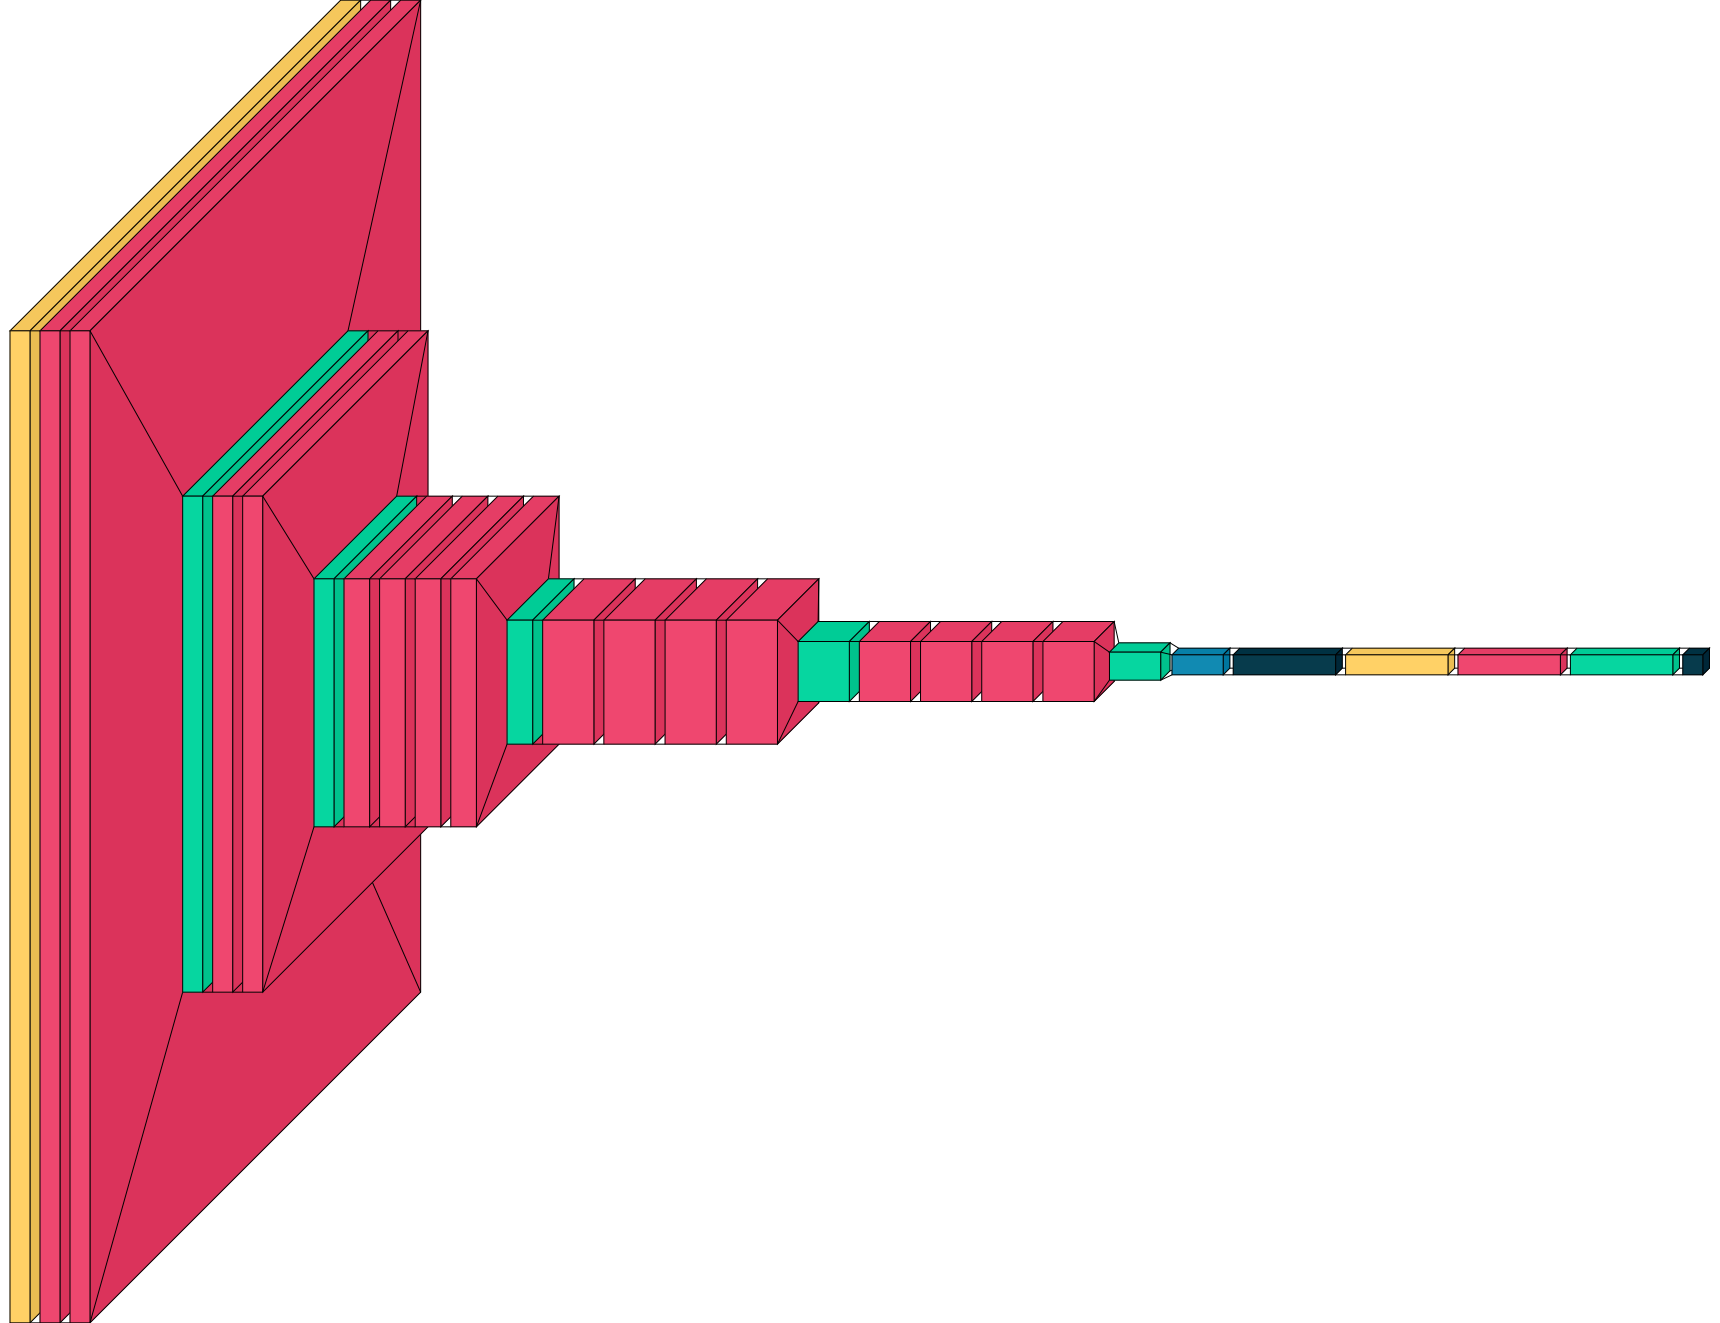

In [ ]:
# import visualkeras

# model = vgg_model

# # visualkeras.layered_view(model).show()
# # visualkeras.layered_view(model, to_file='output.png')
# # visualkeras.layered_view(model, to_file='output.png').show()

# visualkeras.layered_view(model)